In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from datetime import datetime
from collections import defaultdict
import itertools
from random import choices
from collections import Counter
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from math import sqrt,ceil
from sklearn.metrics import mean_squared_error
style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline 
from sklearn import preprocessing, linear_model
from sklearn.linear_model import LassoCV,Lasso, RidgeCV, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize,standardize,
import csv
path = 'd:/ssjiun/Project Folder/data/'

In [ ]:
class PredictiveModel():
    def __init__(self,df,Type):
        self.df = df
        self.Type = Type
        
    def processData(self,features_list):
        if self.Type not in ['Sale','Rent']:
            print('Please key in Type=Sale or Type=Rent')
        else:
            self.variableY = {'Sale':'price','Rent':'Price_persqft'}[self.Type]
        
    def trainModel(self)
    

In [2]:
def modelPrice(dfModel,dfRaw,category,features_list,mtype = 'RF'):
    result_dict = {}
    #features_list = ['furnishing','num_bedroom','num_bath','carpark',
    #            'size'] 
    #if there is categorical column
    if [i for i in features_list if dfModel[i].dtype == 'object']:
        df_categoricalV = pd.get_dummies(dfModel[[i for i in features_list if dfModel[i].dtype == 'object']])

    df_numericalV = dfModel[[i for i in features_list if dfModel[i].dtype != 'object']]
    
    if [i for i in features_list if dfModel[i].dtype == 'object']:
        df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
        #df_features.drop('region_type_', axis = 1,inplace = True)
    else:
        df_features = df_numericalV.copy()
    
    if [i for i in features_list if dfRaw[i].dtype == 'object']:
        df_categoricalV_Raw = pd.get_dummies(dfRaw[[i for i in features_list if dfRaw[i].dtype == 'object']])

    df_numericalV_Raw = dfRaw[[i for i in features_list if dfRaw[i].dtype != 'object']]
    
    if [i for i in features_list if dfRaw[i].dtype == 'object']:
        dfRaw_features = pd.concat([df_numericalV_Raw,df_categoricalV_Raw],
                               join_axes= [df_numericalV_Raw.index],axis = 1).copy()
    else:
        dfRaw_features = df_numericalV_Raw.copy()
    
    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(df_features, dfModel['logPrice'], 
                                                test_size = 0.25, random_state = 42)
    if mtype == 'RF':
        # Instantiate model with 100 decision trees
        rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

    elif mtype == 'LM':
        rf = linear_model.LinearRegression()
    
    elif mtype == 'Lasso':
        alpha_list = np.logspace(-4, 4, 10)
        lasso_CV = LassoCV(alphas = alpha_list, normalize = True, cv = 5).fit(train_X,train_Y)
        print('Model trained. Predicting...')
        train_rmse = np.sqrt(-cross_val_score(lasso_CV, train_X,train_Y,scoring = 'neg_mean_squared_error',cv = 5)).mean()
        test_rmse = sqrt(mean_squared_error(test_Y,lasso_CV.predict(test_X)))
    
    elif mtype == 'Ridge':
        alpha_list = np.logspace(-4, 4, 10)
        ridge_CV = RidgeCV(alphas = alpha_list, normalize = True, cv = 5).fit(train_X,train_Y)
        print('Model trained. Predicting...')
        train_rmse = np.sqrt(-cross_val_score(ridge_CV, train_X,train_Y,scoring = 'neg_mean_squared_error',cv = 5)).mean()
        test_rmse = sqrt(mean_squared_error(test_Y,ridge_CV.predict(test_X)))
        
    if mtype in ['RF','LM']:
        # Train the model on training data
        rf.fit(train_X, train_Y)
        print('Model trained. Predicting...')
        #prediction, get rmse, mape
        train_predictions = rf.predict(train_X)
        train_rmse = sqrt(mean_squared_error(train_Y,train_predictions))
        test_predictions = rf.predict(test_X)
        test_rmse = sqrt(mean_squared_error(test_Y,test_predictions))
        train_absoluteError = abs(train_predictions - train_Y)
        train_mape = 100 - np.mean(100*(train_absoluteError/train_Y))
        test_absoluteError = abs(test_predictions - test_Y)
        test_mape = 100 - np.mean(100*(test_absoluteError/test_Y))
    
    #store result
    if mtype in ['RF','LM']: 
        result_dict[str(category)] = {}
        result_dict[str(category)]['train_rmse'] = train_rmse
        result_dict[str(category)]['test_rmse'] = test_rmse
        result_dict[str(category)]['train_mape'] = round(train_mape,2)
        result_dict[str(category)]['test_mape'] = round(test_mape,2)
    elif mtype in ['Lasso','Ridge']:
        result_dict[str(category)] = {}
        result_dict[str(category)]['train_rmse'] = train_rmse
        result_dict[str(category)]['test_rmse'] = test_rmse
        
    if mtype == 'RF':
        #features importance
        featuresImportance_list = \
        sorted([(i,j) for i,j in zip(df_features.columns,
                rf.feature_importances_)],key = lambda x:x[1],reverse = True)
    elif mtype == 'LM':
        #features coefficients
        featuresImportance_list = \
        sorted([(i,j) for i,j in zip(df_features.columns,
                rf.coef_)],key = lambda x:x[1],reverse = True)
    
    elif mtype == 'Lasso':
        lasso_model = Lasso(alpha = lasso_CV.alpha_).fit(train_X,train_Y)
        featuresImportance_list = \
        sorted([(i,j) for i,j in zip(df_features.columns,
                lasso_model.coef_)],key = lambda x:x[1],reverse = True)
        
    elif mtype == 'Ridge':
        ridge_model = Ridge(alpha = ridge_CV.alpha_).fit(train_X,train_Y)
        featuresImportance_list = \
        sorted([(i,j) for i,j in zip(df_features.columns,
                ridge_model.coef_)],key = lambda x:x[1],reverse = True)   
    
    if mtype in ['RF','LM']:
        return (rf.predict(dfRaw_features),featuresImportance_list,result_dict)
    elif mtype == 'Lasso':
        return (lasso_CV.predict(dfRaw_features),featuresImportance_list,result_dict)
    elif mtype == 'Ridge':
        return (ridge_CV.predict(dfRaw_features),featuresImportance_list,result_dict)    

In [3]:
def getRepricingIndex(df,Type,base_year = 2013,ModelNum = 'Same',ModelType = 'RF'):
    print('your base year: ' + str(base_year))
    BasePrice_dict = {}
    ModelResult_list = []
    Factor_list = []
    AllModelResultdf_list = []
    AllFactordf_list = []
    if ModelType == 'LM':
        columns_list = ['furnishing','num_bedroom','bath','carpark','district_master',
                        'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail','year_str']  
    elif ModelType == 'RF':
        columns_list = ['furnishing_bool','num_bedroom','bath','carpark','district_master',
                        'Type_le','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail','year_str']\
                        + exchangeRate_list + normalized_macro_list
    elif ModelType == 'Lasso':
        columns_list = ['furnishing','num_bedroom','bath','carpark','district_master',
                        'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail','year_str']\
                        + exchangeRate_list + normalized_macro_list
    elif ModelType == 'Ridge':
        columns_list = ['furnishing','num_bedroom','bath','carpark','district_master',
                        'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail','year_str']\
                    + exchangeRate_list + normalized_macro_list
    else:
        print('Please key in valid models: RF for random forest,LM for linear model and Lasso for lasso regression')
    if Type == 'Rent':
        variableY = 'Price_persqft'
    elif Type == 'Sale':
        variableY = 'price'
    
    if base_year==2013:
        ### calculate mean of real log price and estimate log price for base year
        df['logPrice'] = np.log(df[variableY])
        df_base = df[(df['year'] == int(base_year))].copy()
        df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
        print('training model.....')
        df_base['estimatedPrice'],df_baseFeatures,df_baseResult = modelPrice(df_baseUnique,
                                                                df_base,'2013',columns_list,ModelType)
        BasePrice_dict[str(base_year)] = np.mean(df_baseUnique['estimatedPrice'])
        ModelResult_list.append((str(base_year),df_baseResult))
        Factor_list.append((str(base_year),df_baseFeatures))
    
    if ModelNum == 'Same':
        #calculate mean price for years other than 2013
        MeanPrice_dict = {}
        df['logPrice'] = np.log(df[variableY])
        df_subsetUnique = df[columns_list + ['logPrice']].drop_duplicates()
        print('training model.....')
        df['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                                modelPrice(df_subsetUnique,df,'All',columns_list,ModelType)
        ModelResult_list.append(('All',df_subsetResult))
        Factor_list.append(('All',df_subsetFeatures))
        for yearqr in df['year-quarter'].unique():
            MeanPrice_dict[str(yearqr)] = np.mean(df[df['year-quarter'] == yearqr]['estimatedPrice'])
    
    #calculate mean price for years other than 2013,diff model on diff period
    if ModelNum == 'Diff':
        MeanPrice_dict = {}
        df['logPrice'] = np.log(df['price'])
        for yearQ in df['year-quarter'].unique():
            df_subset = df[(df['year-quarter'] == yearQ)].copy()
            df_subsetUnique = df_subset[columns_list + ['logPrice']].drop_duplicates()
            print('training model.....')
            df_subset['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                                modelPrice(df_subsetUnique,df_subset,str(yearQ),columns_list,
                                                          ModelType)
            MeanPrice_dict[str(yearQ)] = np.mean(df_subset['estimatedPrice'])
            ModelResult_list.append((str(yearQ),df_subsetResult))
            Factor_list.append((str(yearQ),df_subsetFeatures))
    
    
    #store model performance result and    
    #save to excel
    df_temp1 = pd.DataFrame([j[i] for i,j in ModelResult_list])
    df_temp1['Category'] = [i[0] for i in ModelResult_list]
    df_temp1.to_excel(path +\
                      '/excel/%sModelResult_Quarter_Price%s%s.xlsx'%(Type,ModelType,ModelNum),index = False)

    #store feature importance result and
    #save to excel
    df_temp2 = pd.DataFrame([j + (i[0],) for i in Factor_list for j in i[1]])
    if ModelType == 'RF':
        df_temp2.columns = ['Feature','FeatureImportance','Category']
    elif ModelType in ['LM','Lasso','Ridge']:
        df_temp2.columns = ['Feature','FeatureCoef','Category']
    df_temp2.to_excel(path + \
                    '/excel/%sFeaturesResult_Quarter_Price%s%s.xlsx'%(Type,ModelType,ModelNum),index = False)

    ### calculate reprice index
    #get number of listing by state,type and year-quarter
    numlistings_dict = {str(i[0]):i[1] for i in 
                    df.groupby(['year-quarter'])['Location_property'].count().reset_index().values}

    #get real price average
    realPrice_dict = {str(i):j for i,j in dict(df.groupby('year-quarter')['price'].mean()).items()}
    
    if base_year == 2013:
        realPrice_baseyear = df[df['year'] == base_year]['price'].mean()
    else:
        realPrice_baseyear = df[df['year-quarter'] == '2013-1']['price'].mean()

    #get ratio of index of raw price
    if base_year == 2013:
        denom_Index = {'2013':MeanPrice_dict['2013']**(1/(numlistings_dict['2013']))}
    else:
        denom_Index = {'2013-1':MeanPrice_dict['2013-1']**(1/(numlistings_dict['2013-1']))} 
    
    numerator_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i]))
                       for i in MeanPrice_dict}

    ratio_Index = {i:numerator_Index[i]/denom_Index['2013-1'] for i in numerator_Index}

    #get ratio of index of quality-adjusted price
    if base_year == 2013:
        PI_dict = {i:np.exp(MeanPrice_dict[i])
                   /np.exp(BasePrice_dict['2013']) for i in MeanPrice_dict}        
    else:    
        PI_dict = {i:np.exp(MeanPrice_dict[i])
                   /np.exp(MeanPrice_dict['2013-1']) for i in MeanPrice_dict}

    #get final index
    reprice_PI_dict = {i:(ratio_Index[i]/PI_dict[i])*100 for i in PI_dict}
    #pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_ByYearQuarter_Price.xlsx')
        
    return (PI_dict,reprice_PI_dict)

# Sales

In [4]:
df_star_sales = pd.read_csv('../data/processed/df_fullfeatures.csv')

#Pre-processing
for i in [i for i in df_star_sales.columns if i.startswith('Closeto')]:
    df_star_sales[i].fillna(False, inplace = True)

df_sales_final = df_star_sales.rename(columns = {'lng_x':'lng','lat_x':'lat'})

df_sales_final = df_sales_final.dropna(subset = ['lat','lng']).copy()

df_sales_final['furnishing_bool'] = df_sales_final['furnishing'].astype(str).map({'Fully Furnished': True,
                                 'Semi-Furnished': True,
                                 'Unfurnished': False,
                                 'nan':False})

#Label Encoder for district
le = preprocessing.LabelEncoder()
le.fit(df_sales_final['district_master_x'].astype(str))
df_sales_final['district_master_le'] = le.transform(df_sales_final['district_master_x'].astype(str))

le2 = preprocessing.LabelEncoder()
le2.fit(df_sales_final['Type'])
df_sales_final['Type_le'] = le2.transform(df_sales_final['Type'])

# Rental

In [10]:
df_star_rental = pd.read_csv('../data/processed/df_Rental_fullfeatures.csv')

#Pre-processing
df_star_rental['num_bedroom'] = df_star_rental['num_bedroom']\
                                            .apply(lambda x : x if x != 0 else 3)
df_star_rental['bath'] = df_star_rental['bath'].astype(int)
df_star_rental['num_bath'] = df_star_rental.apply(lambda row: row['bath'] if row['bath'] != 0 \
                                                          else ceil(row['num_bedroom'] / 2) , axis=1)
for i in [i for i in df_star_rental.columns if i.startswith('Closeto')]:
    df_star_rental[i].fillna(False, inplace = True)
df_star_rental['furnishing_bool'] = df_star_rental['furnishing'].astype(str).map({'Fully Furnished': True,
                                 'Semi-Furnished': True,
                                 'Unfurnished': False,
                                 'nan':False})

#Label Encoder for district
le = preprocessing.LabelEncoder()
le.fit(df_star_rental['district_master'])
df_star_rental['district_master_le'] = le.transform(df_star_rental['district_master'])

le2 = preprocessing.LabelEncoder()
le2.fit(df_star_rental['Type'])
df_star_rental['Type_le'] = le2.transform(df_star_rental['Type'])

#change year to str
df_star_rental['year_str'] = df_star_rental['year'].astype(str)

In [6]:
#External data
df_exchangeRate = pd.read_excel('../data/processed/exchangeRate_processed.xlsx')
df_exchangeRate_grouped = df_exchangeRate[[i for i in df_exchangeRate.columns if i not in ['Unnamed: 0','YearQ','Year']]]\
                            .groupby('YearMonth').mean()

df_macro = pd.read_excel('../data/external/Malaysia-MacroIndicator.xlsx')
df_macro.index.name = 'year'

#export columns
exchangeRate_list = list(df_exchangeRate_grouped.columns)
macro_list = list(df_macro.columns)

with open(path + 'excel/externalData_cols.csv','w',newline = '') as newfile:
    writefile = csv.writer(newfile)
    writefile.writerow(exchangeRate_list)
    writefile.writerow(macro_list)

In [6]:
cols_list = []
with open(path + 'excel/externalData_cols.csv') as newfile:
    readfile = csv.reader(newfile)
    for row in readfile:
        cols_list.append(row)
exchangeRate_list = cols_list[0]
macro_list = cols_list[1]

#tip to open file quickly with notepad
#f = os.popen(path + 'excel/externalData_cols.csv')

In [15]:
df_star_rentalfinal = df_star_rental.rename(columns = {'year_month':'YearMonth'})\
                    .join(df_exchangeRate_grouped,on = 'YearMonth')\
                    .join(df_macro,on = 'year')

df_star_rentalfinal.to_csv('d:/ssjiun/Project Folder/data/processed/propwall_star_rental-6-28-18.csv')

In [4]:
df_star_rentalfinal = pd.read_csv('d:/ssjiun/Project Folder/data/processed/propwall_star_rental-6-28-18.csv')

In [5]:
df_star_rentalfinal_no2017 = df_star_rentalfinal[df_star_rentalfinal['year']!=2017].copy()

In [7]:
for i in macro_list:
    df_star_rentalfinal_no2017[i+'_normalized'] = normalize(df_star_rentalfinal_no2017[i][:,np.newaxis],axis = 0).ravel()

In [8]:
normalized_macro_list = [i for i in df_star_rentalfinal_no2017.columns if i.endswith('_normalized')]

In [21]:
#diskfull
#df_star_rentalfinal.to_csv('../data/processed/df_Rental_fullfeatures_All.csv')

OSError: [Errno 28] No space left on device

# linear Model

In [8]:
#price index based on linear model
#getRepricingIndex(df,Type,base_year = 2013,ModelNum = 'Same',ModelType = 'RF')
#RF -random forest, LM - linear model
PI_result, repricePI_result = getRepricingIndex(df_star_rental,'Rent','2013-1','Same','LM')

your base year: 2013-1


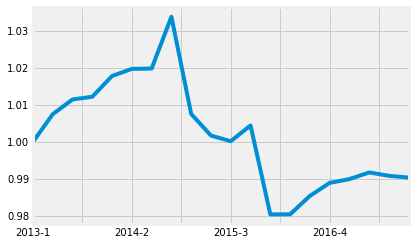

In [9]:
pd.Series(PI_result).plot()

In [10]:
pd.Series({i:j*100 for i,j in PI_result.items()}).to_excel('../data/excel/PriceIndex_LM.xlsx')

# Random Forest

In [58]:
#external factors - ex
PI_result_rf, repricePI_result_rf = getRepricingIndex(df_star_rentalfinal,'Rent','2013-1','Same','RF')

your base year: 2013-1


In [10]:
#external factors
PI_result_rf, repricePI_result_rf = getRepricingIndex(df_star_rentalfinal_no2017,'Rent','2013-1','Same','RF')

your base year: 2013-1
training model.....
Model trained. Predicting...


In [ ]:
#price index based on random forest
#getRepricingIndex(df,Type,base_year = 2013,ModelNum = 'Same',ModelType = 'RF')
PI_result_rf, repricePI_result_rf = getRepricingIndex(df_star_rental,'Rent','2013-1','Same','RF')

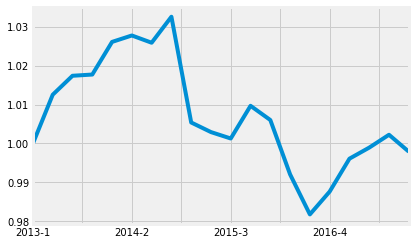

In [14]:
pd.Series(PI_result_rf).plot()

In [13]:
pd.Series({i:j*100 for i,j in PI_result_rf.items()}).to_excel('../data/excel/PriceIndex_RF.xlsx')

# Lasso

In [29]:
PI_result_lasso, repricePI_result_lasso = getRepricingIndex(df_star_rental,'Rent','2013-1','Same','Lasso')

your base year: 2013-1


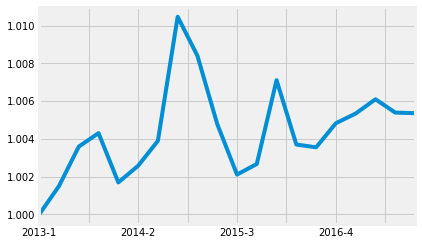

In [30]:
pd.Series(PI_result_lasso).plot()

In [34]:
pd.Series({i:j*100 for i,j in PI_result_lasso.items()}).to_excel('../data/excel/PriceIndex_Lasso.xlsx')

In [21]:
#external factors
PI_result_lasso, repricePI_result_lasso = getRepricingIndex(df_star_rentalfinal_no2017,'Rent','2013-1','Same','Lasso')

your base year: 2013-1
training model.....
Model trained. Predicting...


# Ridge

In [35]:
PI_result_ridge, repricePI_result_ridge = getRepricingIndex(df_star_rental,'Rent','2013-1','Same','Ridge')

your base year: 2013-1


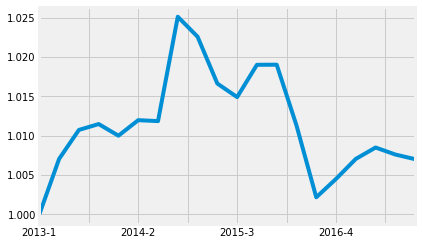

In [12]:
pd.Series(PI_result_ridge).plot()

In [36]:
pd.Series({i:j*100 for i,j in PI_result_ridge.items()}).to_excel('../data/excel/PriceIndex_Ridge.xlsx')

In [9]:
#external factors
PI_result_ridge, repricePI_result_ridge = getRepricingIndex(df_star_rentalfinal_no2017,'Rent','2013-1','Same','Ridge')

your base year: 2013-1
training model.....
Model trained. Predicting...


# Check assumptions of Multiple Linear Regression

In [5]:
#use random forest same model to get top 10 important district
#feature space is too large if all districts are used

df_Importantfeatures = pd.read_excel('../data/excel/RentFeaturesResult_Quarter_PriceRFSame.xlsx')
df_Importantfeatures

Feature  FeatureImportance  \
0                                         num_bedroom              0.292   
1                                     furnishing_bool              0.183   
2                                             Type_le              0.124   
3                                                bath              0.080   
4                                          ClosetoLRT              0.025   
5                                             carpark              0.025   
6                                          ClosetoKTM              0.023   
7                                          ClosetoMRT              0.020   
8                                     ClosetoMonorail              0.012   
9                              district_master_Sepang              0.011   
10                   district_master_Bandar Tun Razak              0.009   
11                      district_master_Petaling Jaya              0.009   
12                         district_master_Ulu Langat              0.009   
13                      district_master_Lembah Pantai              0.008   
14                           district_master_Selayang              0.008   
15                            district_master_Seputeh              0.007   
16                           district_master_Segambut              0.007   
17                             district_master_TEBRAU              0.007   
18                      district_master_Hulu Selangor              0.006   
19                              district_master_Klang              0.006   
20                             district_master_Kepong              0.006   
21                          district_master_Shah Alam              0.006   
22                               district_master_Batu              0.006   
23                        district_master_Subang Jaya              0.005   
24                      district_master_Bukit Bintang              0.005   
25                        district_master_Ampang Jaya              0.005   
26                        district_master_Setiawangsa              0.005   
27                         district_master_Titiwangsa              0.004   
28                         district_master_KOTA BHARU              0.004   
29                        district_master_Wangsa Maju              0.004   
..                                                ...                ...   
50                              district_master_KULAI              0.002   
51  district_master_Majlis Bandaraya Melaka Bersej...              0.002   
52                              district_master_PULAI              0.002   
53                        district_master_TELUK INTAN              0.002   
54                            district_master_PONTIAN              0.001   
55                    district_master_ISKANDAR PUTERI              0.001   
56                      district_master_TANJONG MALIM              0.001   
57                       district_master_Port Dickson              0.001   
58                            district_master_SEGAMAT              0.001   
59                         district_master_IPOH BARAT              0.001   
60                        district_master_JOHOR BAHRU              0.001   
61                            district_master_MERSING              0.001   
62                             district_master_BERUAS              0.001   
63          district_master_Majlis Perbandaran Kangar              0.001   
64                             district_master_TAMBUN              0.001   
65                              district_master_LABIS              0.001   
66                             district_master_GOPENG              0.001   
67                      district_master_BUKIT GANTANG              0.000   
68                             district_master_KAMPAR              0.000   
69           district_master_Majlis Perbandaran Jasin              0.000   
70                      district_master_PADANG RENGAS              0.000   
71                

In [11]:
topdistrict_list = [i for i in df_Importantfeatures['Feature'] 
                    if i.startswith('district_master')][:10]

In [ ]:
#check violation of multicollinearity

In [24]:
x_list = ['furnishing_bool','num_bedroom','bath','carpark','district_master',
        'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail']
df_rental_subset = df_star_rental\
                    [x_list + ['Price_persqft']].copy()

In [25]:
df_rental_Qualitative = pd.get_dummies(df_rental_subset
                [[i for i in x_list if df_rental_subset[i].dtype == 'object']])
df_rental_Quantitative = df_rental_subset[[i for i in x_list if df_rental_subset[i].dtype != 'object']]

In [26]:
df_rental_fullfeatures = pd.concat([df_rental_Qualitative[[i for i in df_rental_Qualitative.columns if i in topdistrict_list or i.startswith('furnishing')
                    or i.startswith('Type')]],df_rental_Quantitative]
                          ,join_axes= [df_rental_Quantitative.index],axis = 1).copy()

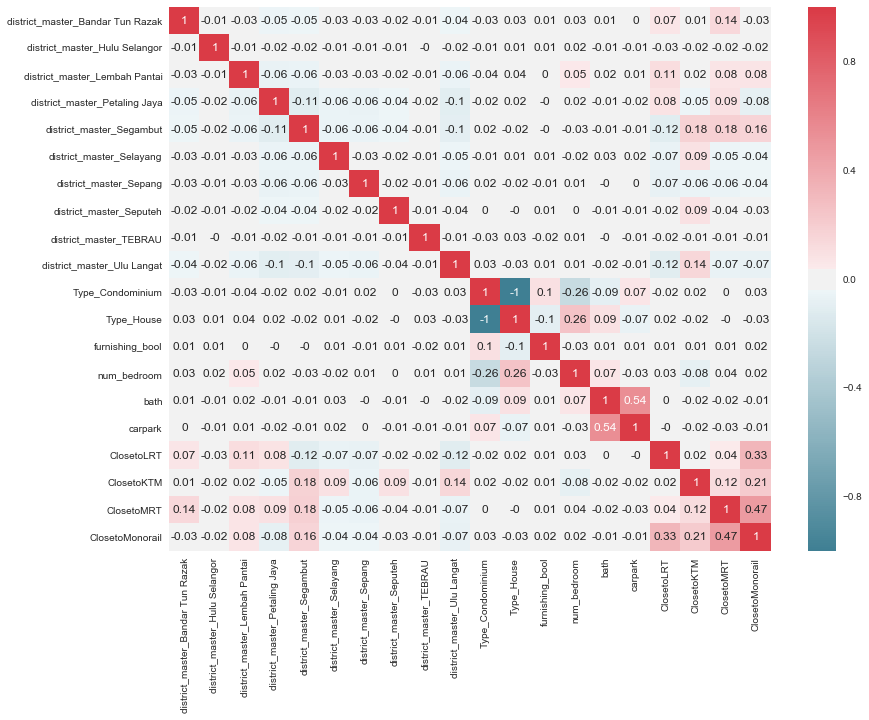

In [28]:
#sns.set(rc = {'axes.facecolor':'white'})
corr = df_rental_fullfeatures.corr()
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr,cmap = cmap,annot = np.around(corr.values, decimals = 2))
g.figure.savefig('../graphs/correlation_x.png', bbox_inches = 'tight',transparent = True,dpi = 140)

In [ ]:
#check linearity between x and y

In [31]:
df_rental_fullfeatures['Price_persqft'] = df_star_rental['Price_persqft']

In [23]:
df_rental_fullfeatures.shape

(486364, 22)

In [ ]:
g = sns.pairplot(df_rental_fullfeatures)

KeyboardInterrupt: 

# Debug

In [79]:
df = df_star_rental.copy()

In [88]:
BasePrice_dict = {}
ModelResult_list = []
Factor_list = []
AllModelResultdf_list = []
AllFactordf_list = []
base_year = '2013-1'
#rental is bath, sales is num_bath
columns_list = ['furnishing','num_bedroom','bath','carpark','district_master',
                    'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail']  
if base_year==2013:
    ### calculate mean of real log price and estimate log price for base year
    df['logPrice'] = np.log(df['price'])
    df_base = df[(df['year'] == int(base_year))].copy()
    df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
    df_baseUnique['estimatedPrice'],df_baseFeatures,df_baseResult = LinearmodelPrice(df_baseUnique,'2013',columns_list)
    BasePrice_dict[str(base_year)] = np.mean(df_baseUnique['estimatedPrice'])
    ModelResult_list.append((str(base_year),df_baseResult))
    Factor_list.append((str(base_year),df_baseFeatures))

#calculate mean price for years other than 2013
MeanPrice_dict = {}
df['logPrice'] = np.log(df['price'])
df_subsetUnique = df[columns_list + ['logPrice']].drop_duplicates()
df['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                    LinearmodelPrice(df_subsetUnique,
                                                     df,'All',columns_list)
ModelResult_list.append(('All',df_subsetResult))
Factor_list.append(('All',df_subsetFeatures))
for yearqr in df['year-quarter'].unique():
    MeanPrice_dict[str(yearqr)] = np.mean(df[df['year-quarter'] == yearqr]['estimatedPrice'])

In [ ]:
alpha_list = np.logspace(-4, 4, 10)
ridge_CV = RidgeCV(alphas = alpha_list, normalize = True, cv = 5).fit(train_X,train_Y)